# Analyzing Data

In this code the goal is to create a figure that contains three different axes. The requirements for the figures are as following:
1. Create a Heatmap
2. Choose any axes type
3. Choose any axes type except barchart, scatterplot oder line diagram

*FYI:* All files were written within a .py file-format. In This case it's different because of the figures. It's more efficiant to show them right away within an .ipynb file, than always safe them and look afterwards.

## Connecting to DB

At first an connection to the dabase is established, to get access to the data. The output of the Code is an SQL-Query, that contains the databasename (first element) und -status (second element). It's just to proof, that the connection was sucessful.
</br></br>
*CAUTION:* The following Code was written for an locally hosted SQL-Server with Windows Authentification.

In [2]:



import pyodbc as odbc

#DRIVER = input(r'Insert Driver name')           # input driver name -> use because of different driver names
#print(f"you choose: {DRIVER} as your driver")   # print driver name for confirmation
DRIVER = 'SQL Server'                           # set driver name to 'SQL Server

#SERVER = input(r'Insert Server name')           # input server name -> use because of different server names
#print(f"you choose: {SERVER} as your server")   # print server name for confirmation

SERVER = f'CUBRIM\SQLEXPRESS'

#DB = input(r'Insert Database name')             # input database name -> use because of different database names
#print(f"you choose: {DB} as your database")     # print database name for confirmation

DB = 'mueller'

# Build Connection
connect_string = f'DRIVER={DRIVER};SERVER={SERVER};DATABASE={DB};Trusted_Connection=yes;'   # build connection string
conn = odbc.connect(connect_string)                                                         # connect to database
cursor = conn.cursor()                                                                      # create cursor object

cursor.execute(f"SELECT DB_NAME() AS DatabaseName, CONVERT(varchar(255),DATABASEPROPERTYEX('master', 'Status')) AS DBStatus")   # small query to get the server status
x = cursor.fetchall()
print(x)                                                                                                                # print query result

[('mueller', 'ONLINE')]


### Heatmap

Heatmap shows the mean approvalquote of approve in general, approve democrats and approve republicans. By quarter and Year

- one start and end year aren't matching
- to keep the work simpler, that isn't 

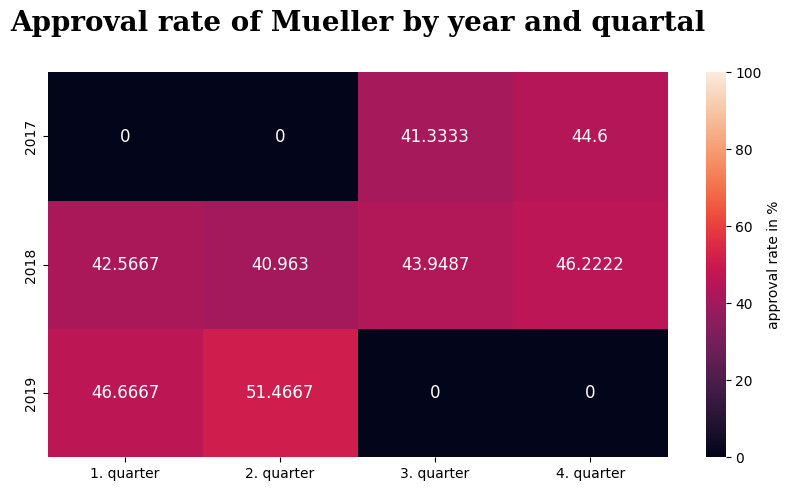

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def convertLisTupleToList(listIN: list)-> list:
    '''used convert list of tuples into one-dimensional list'''
    listOUT = []

    for i in range (0, len(listIN)):
        listOUT.append(listIN[i][0])

    return listOUT


cursor.execute(f"SELECT DISTINCT YEAR(startDate), YEAR(endDate) FROM fact_survey WHERE YEAR(startDate) = YEAR(endDate)")
result_years = cursor.fetchall()
labels_year = convertLisTupleToList(result_years)

cursor.execute(f"SELECT categorie FROM dim_categorieDate")
result_quarters = cursor.fetchall()
labels_quarter = convertLisTupleToList(result_quarters)

cursor.execute(f"SELECT approve, approveDemocrats, approveRepublicans, startQuartal FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2017")
data_2017 = cursor.fetchall()

cursor.execute(f"SELECT approve, approveDemocrats, approveRepublicans, startQuartal FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2018")
data_2018 = cursor.fetchall()

cursor.execute(f"SELECT approve, approveDemocrats, approveRepublicans, startQuartal FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2019")
data_2019 = cursor.fetchall()

def dataYearQuartalMean (data: list)-> list:
    '''used to shape data for specific year and quartal'''
    dataOUT = []

    meanByQ1 = 0
    countDataQ1 = 0

    meanByQ2 = 0
    countDataQ2 = 0

    meanByQ3 = 0
    countDataQ3 = 0

    meanByQ4 = 0
    countDataQ4 = 0

    for i in range (0, len(data)):
        if data[i][3] == '1. quarter':
            countDataQ1 += 3
            meanByQ1 += data[i][0]+data[i][1]+data[i][2]

        elif data[i][3] == '2. quarter':
            countDataQ2 += 3
            meanByQ2 += data[i][0]+data[i][1]+data[i][2]

        elif data[i][3] == '3. quarter':
            countDataQ3 += 3
            meanByQ3 += data[i][0]+data[i][1]+data[i][2]

        elif data[i][3] == '4. quarter':
            countDataQ4 += 3
            meanByQ4 += data[i][0]+data[i][1]+data[i][2]

    if countDataQ1 == 0:
        dataOUT.append(0)
    else:
        meanByQ1 = meanByQ1 / countDataQ1
        dataOUT.append(meanByQ1)

    if countDataQ2 == 0:
        dataOUT.append(0)
    else:
        meanByQ2 = meanByQ2 / countDataQ2
        dataOUT.append(meanByQ2)

    if countDataQ3 == 0:
        dataOUT.append(0)
    else:
        meanByQ3 = meanByQ3 / countDataQ3
        dataOUT.append(meanByQ3)

    if countDataQ4 == 0:
        dataOUT.append(0)
    else:
        meanByQ4 = meanByQ4 / countDataQ4
        dataOUT.append(meanByQ4)

    return dataOUT

data_2017 = dataYearQuartalMean(data_2017)
data_2018 = dataYearQuartalMean(data_2018)
data_2019 = dataYearQuartalMean(data_2019)

heat_array = (data_2017, data_2018, data_2019)

df = pd.DataFrame(heat_array, index=labels_year, columns=labels_quarter)

fig, ax = plt.subplots(figsize=(10,5))

ax = sns.heatmap(df, annot=True, fmt="g", vmin=0, vmax=100, annot_kws={"size": 12}, cbar_kws={'label': 'approval rate in %'})
ax.set_title('Approval rate of Mueller by year and quartal', fontsize=20, pad=30, fontfamily='serif', fontweight='bold', color='black', loc='center')

fig.savefig('images\\HEATMAP_approval_rate_year_quartal.png', dpi=300, bbox_inches='tight')

### Barchart

The barchart was choosen as addition to the heatmap. The heatmap represents the mean of every poll by year and quarter, but it doesn't show how many polls were taken. To get a better look on that topic an barchart was created.

In [1]:
#
labels_year_quarter = []

for j in range (0, len(labels_year)):
    for i in range (0, len(labels_quarter)):
        helpString = str(labels_year[j])+' '+str(labels_quarter[i])
        labels_year_quarter.append(helpString)


def dataYearQuartal (data: list)-> list:
    '''used to get the data for a specific year and quartal'''
    dataOUT = [0,0,0,0]

    for i in range (0, len(data)):
        if data[i][0] == '1. quarter':
            dataOUT[0] = data[i][1]

        elif data[i][0] == '2. quarter':
            dataOUT[1] = data[i][1]

        elif data[i][0] == '3. quarter':
            dataOUT[2] = data[i][1]

        elif data[i][0] == '4. quarter':
            dataOUT[3] = data[i][1]

    return dataOUT

cursor.execute(f"SELECT startQuartal, COUNT(text) FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2017 GROUP BY startQuartal")
data_2017 = cursor.fetchall()

cursor.execute(f"SELECT startQuartal, COUNT(text) FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2018 GROUP BY startQuartal")
data_2018 = cursor.fetchall()

cursor.execute(f"SELECT startQuartal, COUNT(text) FROM all_fact_dim WHERE YEAR(startDate) = YEAR(endDate) AND startQuartal = endQuartal AND YEAR(startDate) = 2019 GROUP BY startQuartal")
data_2019 = cursor.fetchall()

data_2017 = dataYearQuartal(data_2017)
data_2018 = dataYearQuartal(data_2018)
data_2019 = dataYearQuartal(data_2019)

barCharArray = []
barCharArray.extend(data_2017)
barCharArray.extend(data_2018)
barCharArray.extend(data_2019)

df = pd.DataFrame(data=[barCharArray], index=['count'], columns=labels_year_quarter) # data needs to be a 2D array

fig, ax = plt.subplots(figsize=(30,5))
ax = sns.barplot(data=df, palette="Blues_d")
ax.set_xlabel('Year and quartal', fontsize=20, fontfamily='serif', color='black', labelpad=12)
ax.set_ylabel('Number of polls', fontsize=20, fontfamily='serif', color='black', labelpad=12)
ax.set_title('Absolute number of polls taken by year and quartal', fontsize=20, pad=30, fontfamily='serif', fontweight='bold', color='black', loc='center')

fig.savefig('images\\absolute_number_polls_year_quartal.png', dpi=300, bbox_inches='tight')


NameError: name 'labels_year' is not defined

### Strip Plot
-> comment: wie sieht abweichung aus, wo haben Adults und registerd voters teilgenommen und gab es dort mehr oder mindere Zustimmung bei den ein oder anderen

### PairPlot
